# **Optimization for Deep learning**

**Author** : Ryan BOUSTANY

Main goals of this tutorial (3h):

**Session 1:**
- Compute derivatives with Pytorch (autograd/backpropagation)
- Implement a simple gradient method
- Implement gradient method with mini-batch


**Session 2:**
- Build perceptron with Pytorch
- Build a neural network with Pytorch
- Train a perceptron and neural network with mini-batch gradient descent

## **The Basics of PyTorch**

In [174]:
#!pip install torch 
#!pip install torchvision

In [175]:
import torch
print("Using torch", torch.__version__)
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [4, 2]

Using torch 2.0.1


### Tensors
Tensors are the PyTorch equivalent to Numpy arrays, with the addition to also have support for GPU acceleration (more faster). For instance, a vector is a 1-D tensor, and a matrix a 2-D tensor. When working with neural networks, we will use tensors of various shapes and number of dimensions.

Most common functions you know from numpy can be used on tensors as well. Actually, since numpy arrays are so similar to tensors, we can convert most tensors to numpy arrays (and back) but we don’t need it too often.


In [176]:
# Create a tensor from a (nested) list
x = torch.Tensor([[1, 2], [3, 4]])
print(x)

tensor([[1., 2.],
        [3., 4.]])


In [177]:
# Create a tensor with random values between 0 and 1 with the shape [2, 3, 4]
x = torch.rand(2, 3, 4)
print(x)

tensor([[[0.3014, 0.4945, 0.3815, 0.7333],
         [0.6916, 0.2337, 0.8295, 0.4682],
         [0.3736, 0.4899, 0.8480, 0.9905]],

        [[0.7433, 0.5875, 0.8263, 0.2909],
         [0.2387, 0.3556, 0.1764, 0.7150],
         [0.5475, 0.3289, 0.4492, 0.4901]]])


You can obtain the shape of a tensor in the same way as in numpy (`x.shape`), or using the `.size` method:

In [178]:
shape = x.shape
print("Shape:", x.shape)

size = x.size()
print("Size:", size)

dim1, dim2, dim3 = x.size()
print("Size:", dim1, dim2, dim3)

Shape: torch.Size([2, 3, 4])
Size: torch.Size([2, 3, 4])
Size: 2 3 4


### Tensor to Numpy, and Numpy to Tensor

Tensors can be converted to numpy arrays, and numpy arrays back to tensors. To transform a numpy array into a tensor, we can use the function `torch.from_numpy`:

In [179]:
np_arr = np.array([[1, 2], [3, 4]])
tensor = torch.from_numpy(np_arr)

print("Numpy array:", np_arr)
print("PyTorch tensor:", tensor)

Numpy array: [[1 2]
 [3 4]]
PyTorch tensor: tensor([[1, 2],
        [3, 4]])


To transform a PyTorch tensor back to a numpy array, we can use the function `.numpy()` on tensors:

In [180]:
tensor = torch.arange(4)
np_arr = tensor.numpy()

print("PyTorch tensor:", tensor)
print("Numpy array:", np_arr)

PyTorch tensor: tensor([0, 1, 2, 3])
Numpy array: [0 1 2 3]


### Operations

Most operations that exist in numpy, also exist in PyTorch. A full list of operations can be found in the [PyTorch documentation](https://pytorch.org/docs/stable/tensors.html#), but we will review the most important ones here.

The simplest operation is to add two tensors:

In [181]:
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 3)
y = x1 + x2

print("X1", x1)
print("X2", x2)
print("Y", y)

X1 tensor([[0.9287, 0.9463, 0.1151],
        [0.6832, 0.6931, 0.6912]])
X2 tensor([[0.4318, 0.6250, 0.6258],
        [0.9866, 0.0208, 0.3103]])
Y tensor([[1.3605, 1.5714, 0.7409],
        [1.6699, 0.7139, 1.0014]])


Other commonly used operations include matrix multiplications, which are essential for neural networks. Quite often, we have an input vector $\mathbf{x}$, which is transformed using a learned weight matrix $\mathbf{W}$. There are multiple ways and functions to perform matrix multiplication, some of which we list below:

* `torch.matmul`: Performs the matrix product over two tensors, where the specific behavior depends on the dimensions. If both inputs are matrices (2-dimensional tensors), it performs the standard matrix product. For higher dimensional inputs, the function supports broadcasting (for details see the [documentation](https://pytorch.org/docs/stable/generated/torch.matmul.html?highlight=matmul#torch.matmul)). Can also be written as `a @ b`, similar to numpy. 
* `torch.mm`: Performs the matrix product over two matrices, but doesn't support broadcasting (see [documentation](https://pytorch.org/docs/stable/generated/torch.mm.html?highlight=torch%20mm#torch.mm))
* `torch.bmm`: Performs the matrix product with a support batch dimension. If the first tensor $T$ is of shape ($b\times n\times m$), and the second tensor $R$ ($b\times m\times p$), the output $O$ is of shape ($b\times n\times p$), and has been calculated by performing $b$ matrix multiplications of the submatrices of $T$ and $R$: $O_i = T_i @ R_i$

Usually, we use `torch.matmul` or `torch.bmm`. We can try a matrix multiplication with `torch.matmul` below.

In [182]:
x = torch.arange(6)
x = x.view(2, 3)
print("X", x)

X tensor([[0, 1, 2],
        [3, 4, 5]])


In [183]:
W = torch.arange(9).view(3, 3) # We can also stack multiple operations in a single line
print("W", W)

W tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


In [184]:
h = torch.matmul(x, W) # Verify the result by calculating it by hand too!
print("h", h)

h tensor([[15, 18, 21],
        [42, 54, 66]])


## **Autograd and Backpropagation**

One of the main reasons for using PyTorch in Deep Learning projects is that we can automatically get **gradients/derivatives** of functions that we define. We will mainly use PyTorch for implementing neural networks, and they are just fancy functions. If we use weight matrices in our function that we want to learn, then those are called the **parameters** or simply the **weights**.

So, to recap: the only thing we have to do is to compute the **output**, and then we can ask PyTorch to automatically get the **gradients**. 

> **Note:  Why do we want gradients?** Consider that we have defined a function, a neural net, that is supposed to compute a certain output $y$ for an input vector $\mathbf{x}$. We then define an **error measure** that tells us how wrong our network is; how bad it is in predicting output $y$ from input $\mathbf{x}$. Based on this error measure, we can use the gradients to **update** the weights $\mathbf{W}$ that were responsible for the output, so that the next time we present input $\mathbf{x}$ to our network, the output will be closer to what we want.

In [185]:
x = torch.ones((3,))
print(x.requires_grad)

False


We can change this for an existing tensor using the function `requires_grad_()` (underscore indicating that this is a in-place operation). Alternatively, when creating a tensor, you can pass the argument `requires_grad=True` to most initializers we have seen above.

In [186]:
x.requires_grad_(True)
print(x.requires_grad)

True


In order to define a function, we can use elementary functions such as exp, cos, sin...
However, if we want to differentiate them afterwards, we have to use those from pytorch!

In [187]:
x = torch.tensor(1., requires_grad=True) # don't forget the dot after 1 !
f = torch.sin(x) # define sinus in pytorch

print('f(x) =',f)

f(x) = tensor(0.8415, grad_fn=<SinBackward0>)


`grad(f,x)` will now contain the derivative $\partial f/ \partial \mathcal{x}$, and this derivative indicates how a change in $\mathbf{x}$ will affect output $f$ given the current input $\mathbf{x}=1$:

In [188]:
# Pytorch derivative at x=1
print(grad(f, x))

# Hand derivative 
print('cos(1) =', np.cos(1))

(tensor(0.5403),)
cos(1) = 0.5403023058681398


**Question 1**. Compute the gradients at $(1,1)$ of $x^2 + y^2$, of $exp(-(x^2 + y^2)/2 )$ and of $exp(cos(x))$. Compare with the value of the gradient computed by hand.

In [189]:
import torch

# Define x and y with gradient computation enabled
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(1.0, requires_grad=True)

# Define the three functions
def func1(x, y):
    return x**2 + y**2

def func2(x, y):
    return torch.exp(-(x**2 + y**2) / 2)

def func3(x):
    return torch.exp(torch.cos(x))

# Compute gradients using torch.autograd.grad
grad_func1 = torch.autograd.grad(func1(x, y), (x, y), retain_graph=True)
grad_func2 = torch.autograd.grad(func2(x, y), (x, y), retain_graph=True)
grad_func3 = torch.autograd.grad(func3(x), x, retain_graph=True)

# Print the gradients
print(f'Gradient of x^2 + y^2 at (1,1): {grad_func1}')
print(f'Gradient of exp(-(x^2 + y^2)/2) at (1,1): {grad_func2}')
print(f'Gradient of exp(cos(x)) at x = 1: {grad_func3}')

Gradient of x^2 + y^2 at (1,1): (tensor(2.), tensor(2.))
Gradient of exp(-(x^2 + y^2)/2) at (1,1): (tensor(-0.3679), tensor(-0.3679))
Gradient of exp(cos(x)) at x = 1: (tensor(-1.4444),)


**Hand-Computed Gradients:**

For $f(x, y) = x^2 + y^2$,
$$
\frac{\partial f}{\partial x} = 2x, \quad \frac{\partial f}{\partial y} = 2y.
$$
At $x = 1, y = 1$,
$$
\frac{\partial f}{\partial x} = 2, \quad \frac{\partial f}{\partial y} = 2.
$$

For $f(x, y) = \exp\left(-\frac{x^2 + y^2}{2}\right)$,
$$
\frac{\partial f}{\partial x} = -x \exp\left(-\frac{x^2 + y^2}{2}\right), \quad \frac{\partial f}{\partial y} = -y \exp\left(-\frac{x^2 + y^2}{2}\right).
$$
At $x = 1, y = 1$,
$$
\frac{\partial f}{\partial x} = -\frac{e}{2}, \quad \frac{\partial f}{\partial y} = -\frac{e}{2}.
$$

For $f(x) = \exp(\cos(x))$,
$$
\frac{\partial f}{\partial x} = -\sin(x) \exp(\cos(x)).
$$
At $x = 1$,
$$
\frac{\partial f}{\partial x} = -\sin(1) \exp(\cos(1)).
$$


We can also perform backpropagation on the computation graph by calling the function `backward()` on the last output, which effectively calculates the gradients for each tensor that has the property `requires_grad=True`:
Consider the function $f(w) = w \cdot a$. 

In [190]:
w = torch.tensor([0.5, 0.3], requires_grad=True)
a = torch.tensor([0.6, 0.2]) # this is a constant, hence we don't need requires_grad=True

f = torch.dot(w, a)
f.backward()

Now we can access the gradient $\partial f/ \partial \mathcal{w}$:

In [191]:
w.grad

tensor([0.6000, 0.2000])

However, `backward()` sum old gradients in `w.grad` (for some practical reason in deep learning).

In [192]:
w = torch.tensor([0.5, 0.3], requires_grad=True)
a = torch.tensor([0.6, 0.2]) # this is a constant, hence we don't need requires_grad=True

fx = torch.dot(w, a)
fx.backward()

# I "update" fx (but it is still the same) and I call backward a second time...
fx = torch.dot(w, a)
fx.backward()


print(w.grad)
print('this is not the gradient of fx!')

tensor([1.2000, 0.4000])
this is not the gradient of fx!


Before computing a new gradient, you need to set the old gradient to zero with `grad.zero_()`.

In [193]:
# correct update
w.grad.zero_()
fx = torch.dot(w, a)
fx.backward()
print(w.grad.data)

tensor([0.6000, 0.2000])


## **Optimization and Gradient Descent method**

Optimization, in the mathematical sense, involves the process of finding the maximum or minimum value of a function subject to certain constraints. In machine learning, optimization plays an essential role in minimizing a cost function, thereby enabling the model to make accurate predictions.
Mathematically, the optimization problem can be formulated as:
\begin{align*}
\min_{\theta} f(\theta)
\end{align*}
where $\theta$ represents the parameters of the model, and $f(\theta)$ is the cost function to be minimized.

### Basics of Gradient Descent

The Gradient Descent algorithm is an iterative optimization algorithm used for finding the minimum of a function. Given a function $f(\theta)$, the algorithm updates the parameters $\theta$ using the negative of the gradient $\nabla f(\theta)$.

The update rule for Gradient Descent is given by:
\begin{align*}
\theta_{\text{new}} = \theta_{\text{old}} - \alpha \nabla f(\theta_{\text{old}})
\end{align*}

where $\alpha$ is the learning rate, a hyperparameter that determines the step size during each iteration.


**Question 2.**  Implement the gradient method on the function $f(x,y) = 0.5x^2 + y^2 + 0.1xy$. Plot the trajectory of the iterates.

In [194]:
# Initialize variables
x, y = torch.tensor([10.0], requires_grad=True), torch.tensor([10.0], requires_grad=True)
learning_rate = 0.1
iterations = 100

# Store the initial values to plot later
x_vals, y_vals = [x.item()], [y.item()]

# Gradient Descent Loop
for i in range(iterations):
    # Define the function f(x, y)
    f = 0.5 * x ** 2 + y ** 2 + 0.1 * x * y
    
    # Compute gradients
    f.backward()
    
    # Update x and y using gradient descent
    with torch.no_grad():
        x -= learning_rate * x.grad ## TO DO
        y -= learning_rate * y.grad ## TO DO

    # Zero the gradients for the next iteration
    x.grad.zero_()
    y.grad.zero_()
    
    # Store the new values to plot later
    x_vals.append(x.item())
    y_vals.append(y.item())


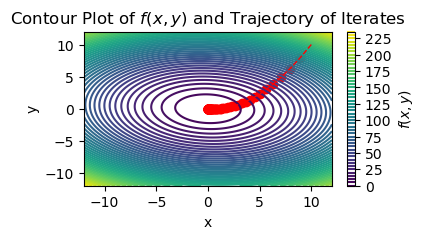

In [195]:
# Generate meshgrid for contour plot
x_range = np.linspace(-12, 12, 400)
y_range = np.linspace(-12, 12, 400)
X, Y = np.meshgrid(x_range, y_range)
Z = 0.5 * X**2 + Y**2 + 0.1 * X * Y

# Plotting the contour plot of f and the trajectory
plt.title('Contour Plot of $f(x, y)$ and Trajectory of Iterates')
plt.xlabel('x')
plt.ylabel('y')
plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='$f(x, y)$')
plt.scatter(x_vals, y_vals, c='red', marker='o')
plt.plot(x_vals, y_vals, c='red', linestyle='--', linewidth=1)
plt.show()


Verification by hand : 
The gradient of $f$ with respect to $(x, y)$ is given by:

\begin{align}
\nabla f(x, y) = \left( \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right) = (x + 0.1y, 2y + 0.1x)
\end{align}

$(x,y)=(0,0)$ is indeed a minimum for $f$.


### Stochastic Gradient Descent (SGD) with mini-batch size

**What is a Mini-batch?**

In the context of machine learning, you often have a dataset comprising $N$ data points. In standard (batch) Gradient Descent, you use the entire dataset to compute the gradient of the loss function and update the parameters $\theta$. This becomes computationally expensive as $N$ grows large.

Stochastic Gradient Descent (SGD) mitigates this by randomly selecting a subset of $n$ data points from the dataset, where $n \ll N$. This subset is known as a "mini-batch," denoted as $\mathcal{B}$.

**Mathematical formulation**

Given a loss function $L(\theta)$ that is an average loss over all $N$ data points:

\begin{align*}
L(\theta) = \frac{1}{N} \sum_{i=1}^{N} l(\theta; x_i, y_i)
\end{align*}

The mini-batch loss $L_{\mathcal{B}}(\theta)$ is the average loss computed over the $n$ data points in $\mathcal{B}$:

\begin{align*}
&L_{\mathcal{B}}(\theta) = \frac{1}{n} \sum_{i \in \mathcal{B}} l(\theta; x_i, y_i) \\
& |\mathcal{B}| = n, \ \mathcal{B} \text{ sampled uniformly in}  \{1, \ldots, N\}
\end{align*}


**Role in SGD**

Using this mini-batch, the gradient is computed as an approximation of the true gradient calculated using the entire dataset. The update rule in SGD becomes:

\begin{align*}
\theta_{t+1} = \theta_t - \alpha \nabla L_{\mathcal{B}}(\theta_t)
\end{align*}



**Question 3.**  Implement the stochastic gradient method on the function $l(\theta,x,y) = (\theta \times x - y)^2$ where $y = 3x + \epsilon$ and $\epsilon \sim N(0,1)$. Plot the trajectory of the iterates.

Hint: $\theta \sim 3$. Why ?

In [196]:
# Generate synthetic data
torch.manual_seed(0)
N = 1000
x_data = torch.randn(N, 1)
y_data = 3 * x_data + torch.randn(N, 1)  # true theta is 3 #TO DO

# Initialize variables
theta = torch.tensor([1.0], requires_grad=True)  # Start with theta=1
learning_rate = 0.1
iterations = 100
batch_size = 10

# Store initial theta for plotting
theta_vals = [theta.item()]
loss_vals = []


# SGD Loop
for i in range(iterations):
    # Randomly select a mini-batch
    indices = np.random.choice(N, batch_size)
    x_batch = x_data[indices]
    y_batch = y_data[indices]
    
    # Compute MSE loss based on mini-batch
    y_pred = theta * x_batch
    loss = torch.mean((y_pred - y_batch) ** 2)
    loss_vals.append(loss.item())
    
    # Compute gradient
    loss.backward()
    
    # Update theta using gradient descent
    with torch.no_grad():
        theta -= learning_rate * theta.grad
    
    # Zero gradient for the next iteration
    theta.grad.zero_()
    
    # Store new theta for plotting
    theta_vals.append(theta.item())


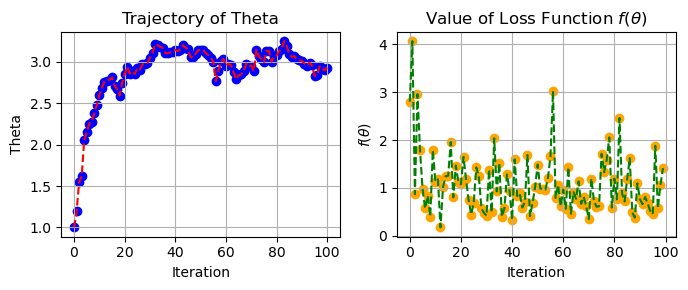

In [197]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

# Plot the trajectory of theta
axs[0].set_title('Trajectory of Theta')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Theta')
axs[0].plot(range(iterations + 1), theta_vals, 'r--')
axs[0].scatter(range(iterations + 1), theta_vals, c='blue')
axs[0].grid(True)

# Plot the value of the loss function f(theta)
axs[1].set_title('Value of Loss Function $f(\\theta)$')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('$f(\\theta)$')
axs[1].plot(range(iterations), loss_vals, 'g--')
axs[1].scatter(range(iterations), loss_vals, c='orange')
axs[1].grid(True)

plt.tight_layout()
plt.show()


**Question 4.**  Do the same but change the value of the learning_rate with 0.01, 0.001. Increase the numbers of iterations. What do you observe ? Do you same with the batch size ? 

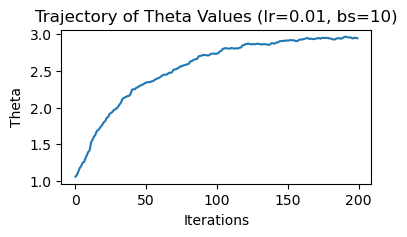

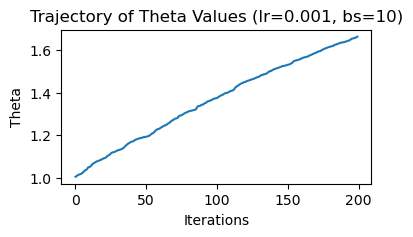

In [198]:
def run_sgd(learning_rate, iterations, batch_size):
    theta = torch.tensor([1.0], requires_grad=True)
    theta_vals = []
    # SGD Loop
    for i in range(iterations):
        # Randomly select a mini-batch
        indices = np.random.choice(N, batch_size)
        x_batch = x_data[indices]
        y_batch = y_data[indices]
    
        # Compute MSE loss based on mini-batch
        y_pred = theta * x_batch
        loss = torch.mean((y_pred - y_batch) ** 2)
        loss_vals.append(loss.item())
    
        # Compute gradient
        loss.backward()
    
        # Update theta using gradient descent
        with torch.no_grad():
            theta -= learning_rate * theta.grad
    
        # Zero gradient for the next iteration
        theta.grad.zero_()
    
        # Store new theta for plotting
        theta_vals.append(theta.item())
    
    plt.plot(theta_vals)
    plt.xlabel('Iterations')
    plt.ylabel('Theta')
    plt.title(f'Trajectory of Theta Values (lr={learning_rate}, bs={batch_size})')
    plt.show()

# Experiment with different learning rates and batch sizes
run_sgd(learning_rate=0.01, iterations=200, batch_size=10)
run_sgd(learning_rate=0.001, iterations=200, batch_size=10)


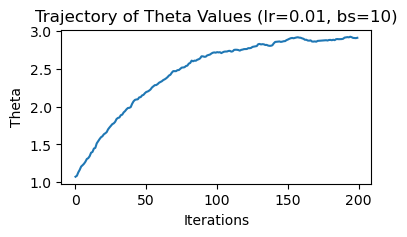

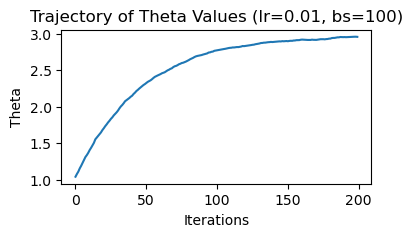

In [199]:
run_sgd(learning_rate=0.01, iterations=200, batch_size=10)
run_sgd(learning_rate=0.01, iterations=200, batch_size=100)


In the experiments, you will likely observe that a smaller learning rate may require more iterations to converge to the true value of θ (which is 3), and a larger batch size might lead to smoother trajectories as the gradient estimate is less noisy.

**Question 5.**  Do the same but remove the noise $\epsilon$. What do you observe ?

In [200]:
# Generate synthetic data without noise
y_data_no_noise = 3 * x_data  # Now, y = 3x exactly

def run_sgd_no_noise(learning_rate, iterations, batch_size):
    theta = torch.tensor([1.0], requires_grad=True)  # Start with theta=1
    theta_vals = []  # Store initial theta for plotting
    
    for i in range(iterations):
        # Randomly select a mini-batch
        indices = np.random.choice(N, batch_size)
        x_batch = x_data[indices]
        y_batch = y_data_no_noise[indices]  # Use data without noise
        
        # Compute MSE loss based on mini-batch
        y_pred = theta * x_batch
        loss = torch.mean((y_pred - y_batch) ** 2)
        
        # Compute gradient
        loss.backward()
        
        # Update theta using gradient descent
        with torch.no_grad():
            theta -= learning_rate * theta.grad
        
        # Zero gradient for the next iteration
        theta.grad.zero_()
        
        # Store new theta for plotting
        theta_vals.append(theta.item())

    # Plot the trajectory of theta values
    plt.plot(theta_vals)
    plt.xlabel('Iterations')
    plt.ylabel('Theta')
    plt.title(f'Trajectory of Theta Values (lr={learning_rate}, bs={batch_size}) - No Noise')
    plt.show()

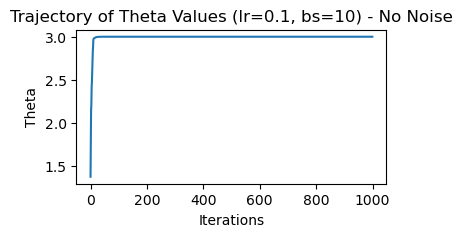

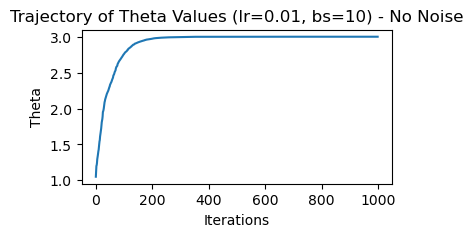

In [201]:
# Experiment with different learning rates and batch sizes
run_sgd_no_noise(learning_rate=0.1, iterations=1000, batch_size=10)
run_sgd_no_noise(learning_rate=0.01, iterations=1000, batch_size=10)

In the updated code above, the y_data_no_noise variable contains the noise-free data, and the run_sgd_no_noise function performs SGD on this data. When you run this code, you should observe that the convergence to 
$\theta=3$ is smoother and likely faster compared to the noisy scenario, especially if you experiment with different learning rates and batch sizes.